# Patchset Experiments

In [90]:
from pathlib import Path
from glob import glob
import netCDF4
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import CROP_ENCODING

## A function to produce monthly band data for the growing season

In [64]:
def monthly_band_data(band, year):

    # Or maybe aggregate based on a given frequency
    # Refer to
    # https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases
    group_freq = '1MS'
    
    # output intervals
    date_range = pd.date_range(start=f'{year}-01-01', end=f'{int(year) + 1}-01-01', freq=group_freq)

    band_data = band.groupby_bins(
        'time',
        bins=date_range,
        right=True,
        include_lowest=False,
        labels=date_range[:-1]
    ).mean(dim='time').interpolate_na(
        dim='time_bins', method='linear', fill_value='extrapolate'
    )[3:9]

    return band_data

## A function to load band data and display parameters from a patch into a dict

In [67]:
def load_patch_file(patch_file):
    patch = netCDF4.Dataset(Path(patch_file), 'r')
    B02 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B02'])).B02
    B03 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B03'])).B03
    B04 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B04'])).B04
    B08 = xr.open_dataset(xr.backends.NetCDF4DataStore(patch['B08'])).B08
    return patch, {
        'B02':  {
            'title': 'B02 - Blue',
            'band': B02,
            'uint8': np.array((B02 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B02, patch.patch_year),
            'plotc': 'b'
            },
        'B03': {
            'title': 'B03 - Green',
            'band': B03,
            'uint8': np.array((B03 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B03, patch.patch_year),
            'plotc': 'g'
        },
        'B04':   {
            'title': 'B04 - Red',
            'band': B04,
            'uint8': np.array((B04 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B03, patch.patch_year),
            'plotc': 'r'
        },
        'B08':   {
            'title': 'B08 - NIR',
            'band': B08,
            'uint8': np.array((B08 / 16).astype(np.uint8)),
            'monthly': monthly_band_data(B03, patch.patch_year),
            'plotc': 'y'
        },
        'parcels': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['parcels'])),
        'labels': xr.open_dataset(xr.backends.NetCDF4DataStore(patch['labels'])),
        'name': patch.patch_name,
        'file': patch_file,
        'year': patch.patch_year,
        'patch_country_code': patch.patch_country_code
    }

## Access the NetCDF files

In [74]:
files = sorted(glob('dataset/netcdf/*.nc'))
print(f'{len(files)} NetCDF4 files')
print(files[0:5])
%time patch, patch_data = load_patch_file(files[2])
patch

300 NetCDF4 files
['dataset/netcdf/2019_31TBF_patch_17_11.nc', 'dataset/netcdf/2019_31TBF_patch_17_12.nc', 'dataset/netcdf/2019_31TBF_patch_17_13.nc', 'dataset/netcdf/2019_31TBF_patch_18_11.nc', 'dataset/netcdf/2019_31TBF_patch_18_12.nc']
CPU times: user 9.43 s, sys: 54.3 ms, total: 9.48 s
Wall time: 9.52 s


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: S4A Patch Dataset
    authors: Papoutsis I., Sykas D., Zografakis D., Sdraka M.
    patch_full_name: 2019_31TBF_patch_17_13
    patch_year: 2019
    patch_name: patch_17_13
    patch_country_code: ES
    patch_tile: 31TBF
    creation_date: 27 Apr 2021
    references: Documentation available at .
    institution: National Observatory of Athens.
    version: 21.03
    _format: NETCDF4
    _nco_version: netCDF Operators version 4.9.1 (Homepage = http://nco.sf.net, Code = http://github.com/nco/nco)
    _xarray_version: 0.17.0
    dimensions(sizes): 
    variables(dimensions): 
    groups: B01, B02, B03, B04, B05, B06, B07, B08, B09, B10, B11, B12, B8A, labels, parcels

## Show all images available for one band in one patch in one patch file

27 4 7 21


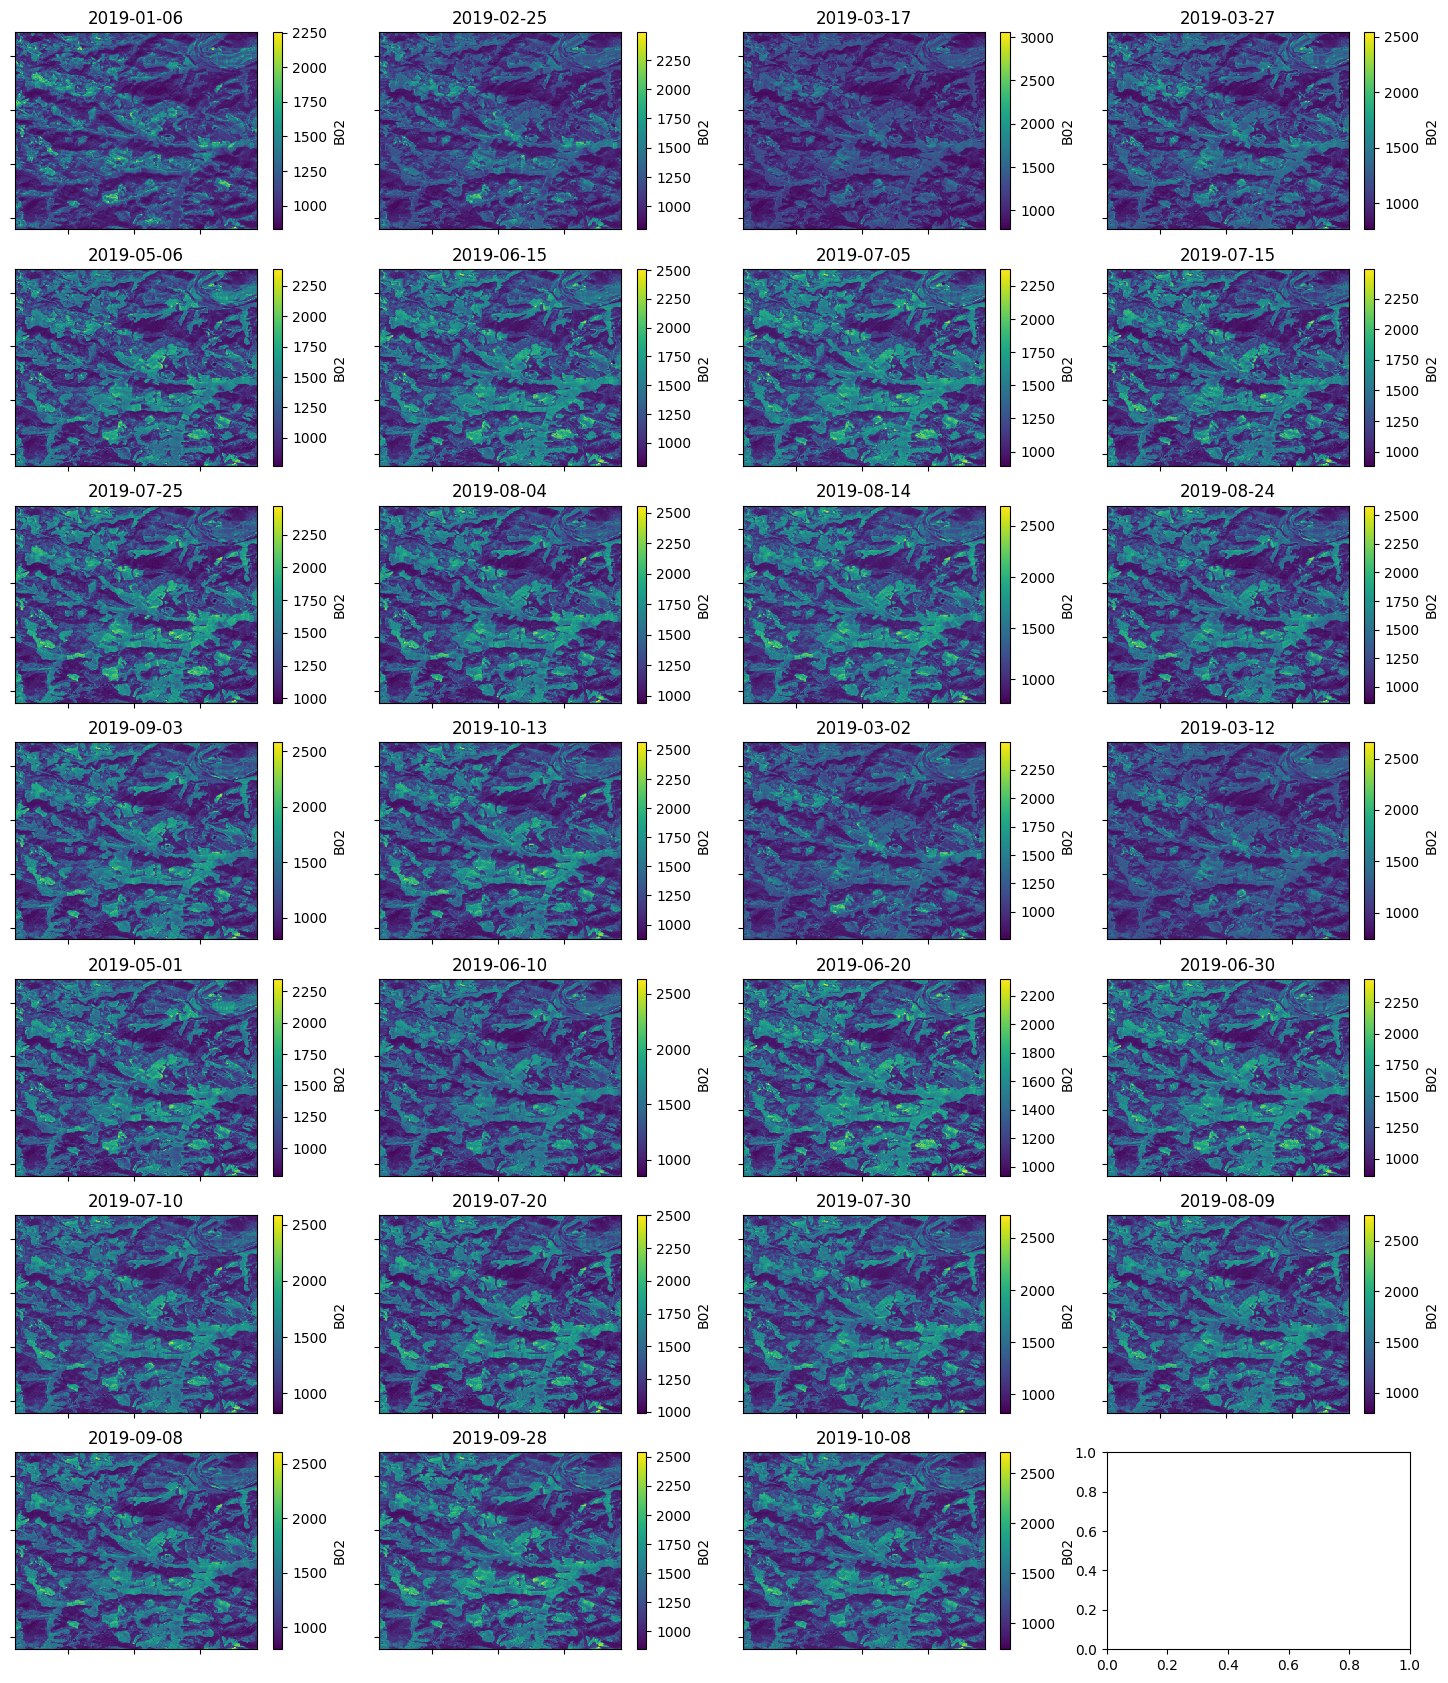

In [77]:
nimages = len(patch_data['B02']['band'].time)
ncols = 4
nrows = (nimages + ncols - 1) // ncols
height = nrows * 3
print(nimages, ncols, nrows, height)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, height))

for i, season in enumerate(patch_data['B02']['band']):
    if i >= nimages: break
    ax = axes.flat[i]
    cax = patch_data['B02']['band'].isel(time=i).plot(ax=ax)

for i, ax in enumerate(axes.flat):
    if i >= nimages: break
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    #ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'{patch_data["B02"]["band"].isel(time=i).time.dt.strftime("%Y-%m-%d").values}')

plt.show()

## Plot monthly data from one band for the growing season

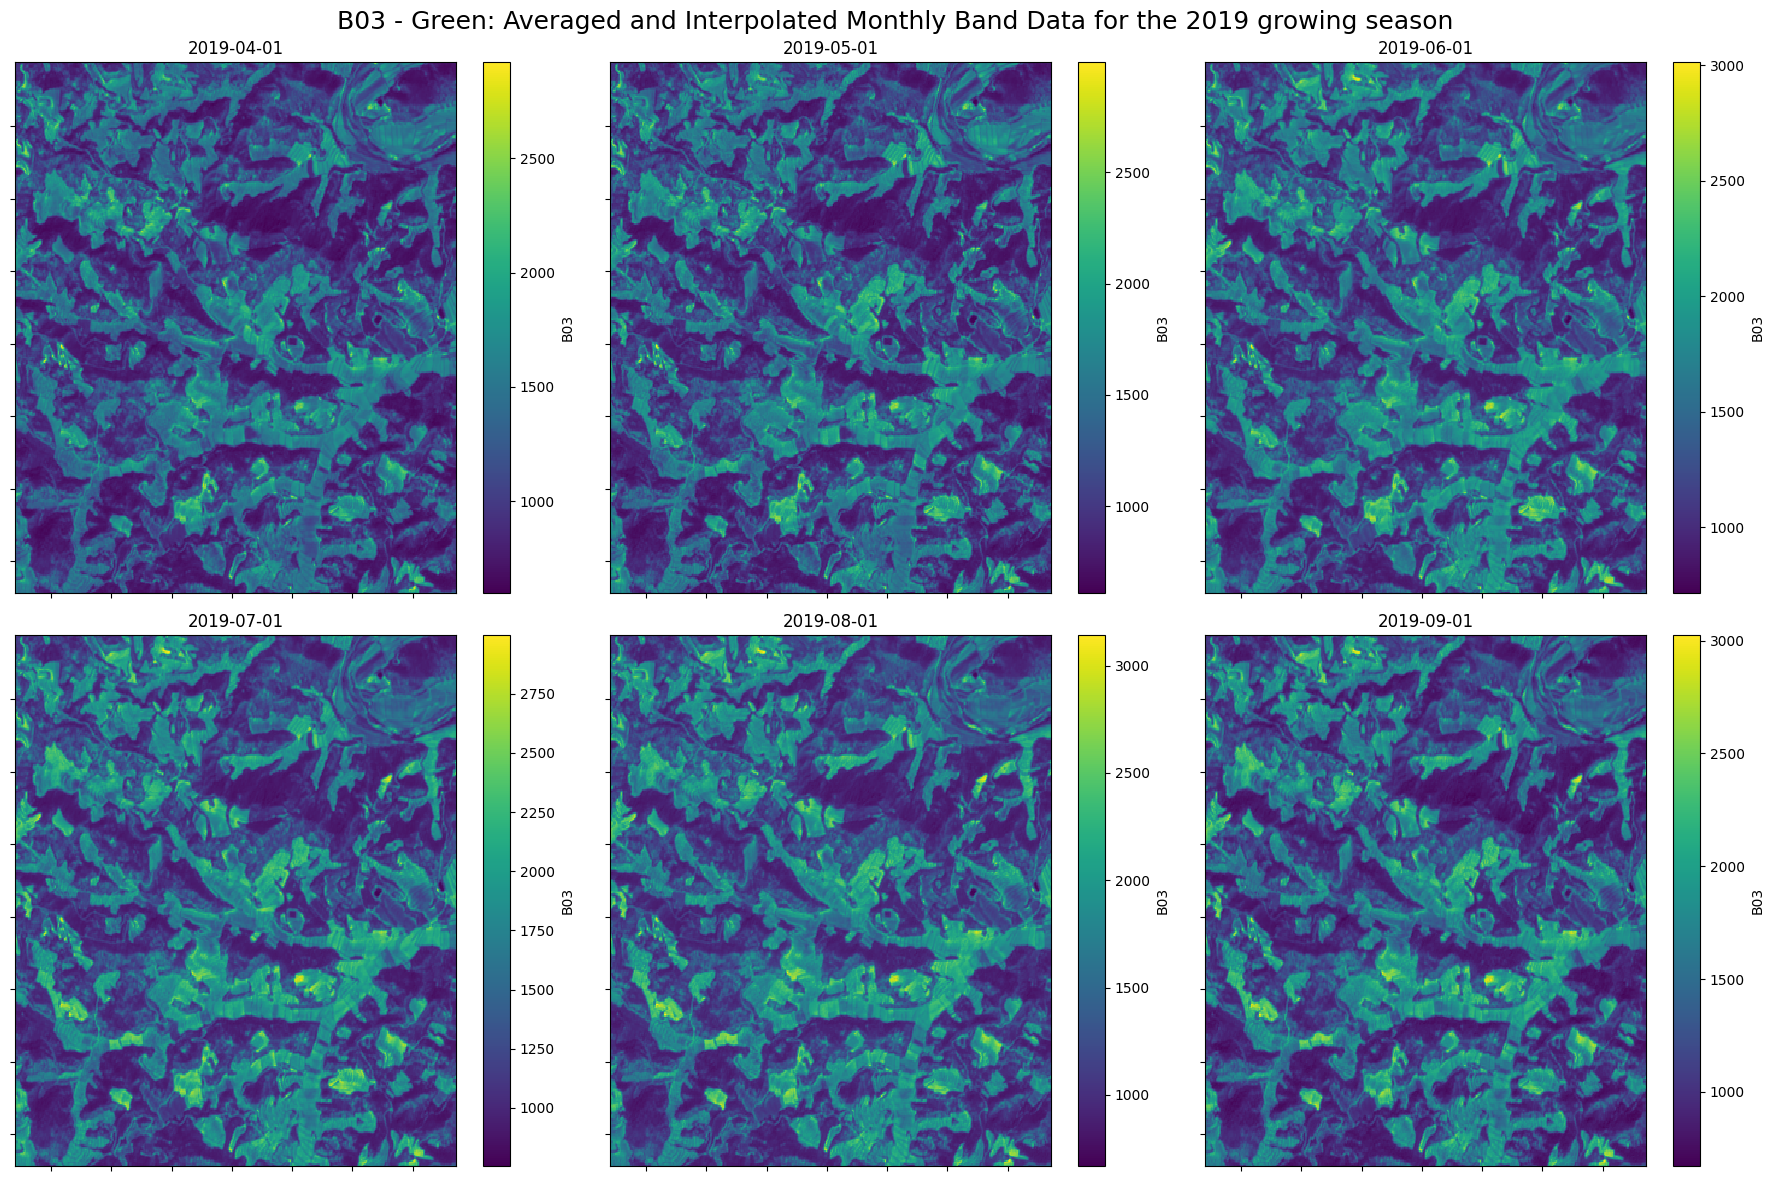

In [79]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
fig.suptitle(f'{patch_data["B03"]["title"]}: Averaged and Interpolated Monthly Band Data for the {year} growing season', fontsize=18)
    
for i, season in enumerate(patch_data['B03']['monthly']):
    ax = axes.flat[i]
    cax = band_data.isel(time_bins=i).plot(ax=ax)

for i, ax in enumerate(axes.flat):
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'{band_data.isel(time_bins=i).time_bins.dt.strftime("%Y-%m-%d").values}')

plt.tight_layout()
plt.show()

## Display band data, labels, and parcels

4 unique label indexes: [  0 330 353 442]
10 unique parcel ids: [      0 1097690 1098397 1098423 1098440 1098450 1098456 1100732 1100733
 1100734]


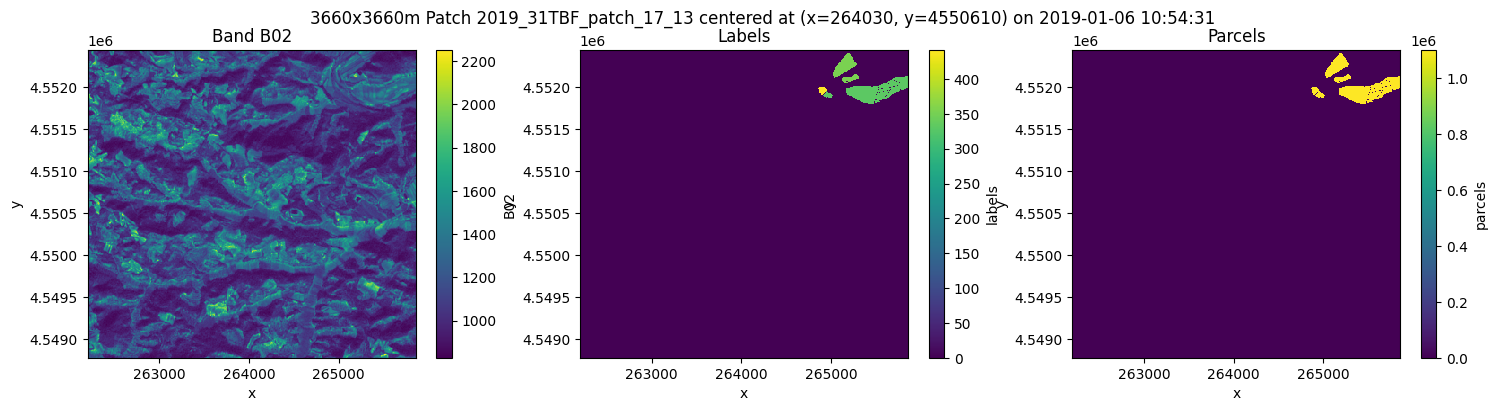

In [83]:
def show_patch(patch_data, time=0):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

    # Extract location information -- only available in the parcel group
    x = (np.array(patch_data['parcels'].coords['x'])[-1] + np.array(patch_data['parcels'].coords['x'])[0]) / 2
    y = (np.array(patch_data['parcels'].coords['y'])[-1] + np.array(patch_data['parcels'].coords['y'])[0]) / 2
    band_data = patch_data['B02']['band']

    # Extract time information
    ftime = band_data.isel(time=time).time.dt.strftime("%Y-%m-%d %H:%M:%S").values
    fig.suptitle(f'3660x3660m Patch {patch.patch_full_name} centered at (x={x:.0f}, y={y:.0f}) on {ftime}')
    
    band_data.isel(time=time).plot(ax=ax[0])
    ax[0].set_title(f'Band B02')

    labels = np.unique(patch_data['labels'].to_dataarray())
    print(f'{len(labels)} unique label indexes:', labels)
    patch_data['labels'].labels.plot(ax=ax[1])
    ax[1].set_title('Labels')

    parcels = np.unique(patch_data['parcels'].parcels)
    print(f'{len(parcels)} unique parcel ids:', parcels)
    patch_data["parcels"].parcels.plot(ax=ax[2])
    ax[2].set_title(f'Parcels')

show_patch(patch_data)

### Define directions

Arbitrarily decide that the positive directions are east and south, due to the increasing directions in our dataset

_look for negative numbers as an indication of an error in calculations_

In [84]:
def west(patch_data):
    return np.sort(np.array(patch_data['parcels'].coords['x']))[0]

def east(patch_data):
    return np.sort(np.array(patch_data['parcels'].coords['x']))[-1]

def north(patch_data):
    return np.sort(np.array(patch_data['parcels'].coords['y']))[0]

def south(patch_data):
    return np.sort(np.array(patch_data['parcels'].coords['y']))[-1]

def rangex(patch_data):
    return east(patch_data) - west(patch_data)
    
def rangey(patch_data):
    return south(patch_data) - north(patch_data)

print('west:', west(patch_data))
print('east:', east(patch_data))
print('north:', north(patch_data))
print('south:', south(patch_data))

west: 262205.0
east: 265855.0
north: 4548785.0
south: 4552435.0


## List labels for a patch

In [94]:
def get_label_list(patch_data):
    label_array = np.array(patch_data['labels'].to_dataarray()[0])
    return np.unique(label_array)

def decode_labels(labels):
    CROP_DECODING = dict((v,k) for k, v in CROP_ENCODING.items())
    CROP_DECODING[0] = "UNDEFINED"
    return np.vectorize(CROP_DECODING.get)(unique_indexes)[1:]

unique_indexes = get_label_list(patch_data)
print('Crop labels:', unique_indexes)

fields = decode_labels(unique_indexes)
print('Crops:', fields)

Crop labels: [  0 330 353 442]
Crops: ['Grapes' 'Cherries and sour cherries' 'Olives']


## Highlight Label Bounding Boxes

* Read a mask image (such as a crop label)
* Draw an outline around labeled pixels
* Allow width specification
* Clear the original label

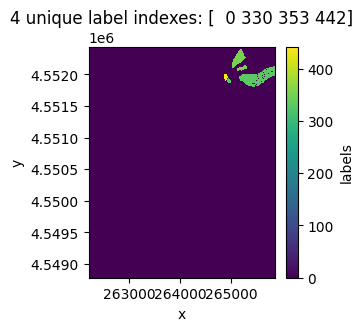

In [101]:
def draw_outline_image(image, color=1, width=3):
    outline_image = image.copy()
    
    # TODO: determine how to do this without a loop; maybe consider generic_filter
    for w in range(width):
        indicies = np.where((outline_image > 0))
        ai = np.array(indicies) + 1
        for addsub in [-1, 1]:
            for idx in range(2):
                for n in range(2):
                    ai=np.clip(ai, 0, 365)
                    outline_image[tuple(ai)] = color
                    ai[idx] = np.array(indicies)[idx] + addsub
    
    # Remove center
    outline_image[image > 0] = 0
    return outline_image


fig, ax = plt.subplots(figsize=(3, 3))
labels = np.unique(patch_data['labels'].to_dataarray())
_ = patch_data['labels'].labels.plot(ax=ax)
_ = ax.set_title(f'{len(labels)} unique label indexes: {labels}')

## A function to draw all 4 band histograms of an entire patch

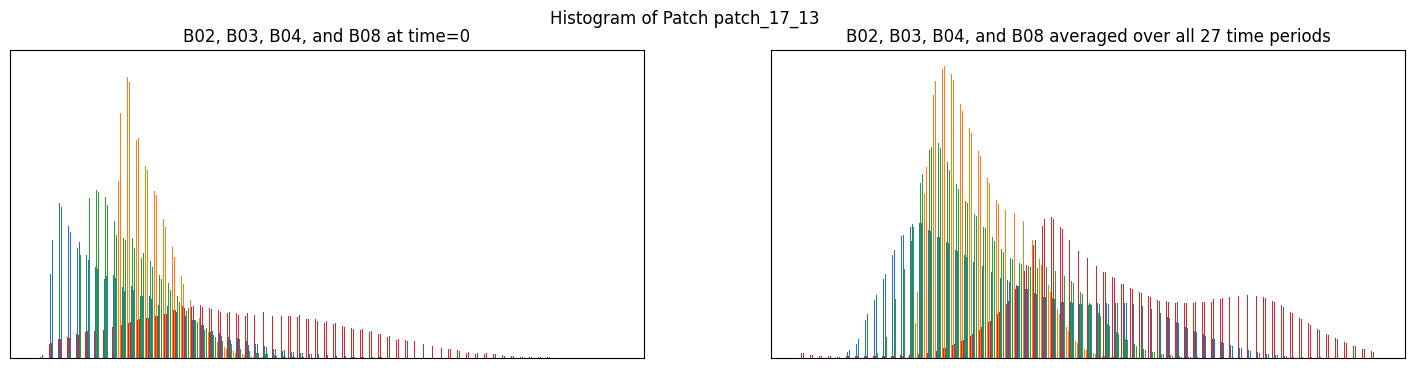

In [102]:
def draw_patch_histogram(patch_data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
    fig.suptitle(f'Histogram of Patch {patch_data["name"]}')
    ax0 = axes[0].hist([
            np.array(patch_data['B04']['band'].isel(time=0)).flatten(),
            np.array(patch_data['B02']['band'].isel(time=0)).flatten(),
            np.array(patch_data['B03']['band'].isel(time=0)).flatten(),
            np.array(patch_data['B08']['band'].isel(time=0)).flatten()
    ], bins=256)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    _ = axes[0].set_title(f'B02, B03, B04, and B08 at time=0')
    ax1 = axes[1].hist([
            patch_data['B04']['uint8'].flatten(),
            patch_data['B02']['uint8'].flatten(),
            patch_data['B03']['uint8'].flatten(),
            patch_data['B08']['uint8'].flatten()
    ], bins=256)
    _ = axes[1].set_title(f'B02, B03, B04, and B08 averaged over all {patch_data["B04"]["uint8"].shape[0]} time periods')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    plt.show()

draw_patch_histogram(patch_data)